In [37]:
%matplotlib inline
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from netCDF4 import Dataset
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

In [46]:
filename = 'clampstropoe10.aeri.v0.C2.20241104.011005.nc'
nc = Dataset(filename, 'r')
# Print out the netCDF header so you know what's in there
print (nc)

# Grab the times, heights, and data we're interested in 
times = np.array([datetime.utcfromtimestamp(d) for d in nc['base_time'][0]+nc['time_offset'][:]])
heights = nc['height'][:] * 1e3
temp = nc['temperature'][:]
watervapor = nc['waterVapor'][:]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    algorithm_code: TROPoe Retrieval Code (formerly AERIoe)
    algorithm_authors: Dave Turner, NOAA Global Systems Laboratory (dave.turner@noaa.gov), Josh Gebauer, NOAA National Severe Storms Laboratory / CIWRO (joshua.gebauer@noaa.gov), Tyler Bell, NOAA National Severe Storms Laboratory / CIWRO (tyler.bell@noaa.gov)
    algorithm_comment1: TROPoe is a physical-iterative algorithm that retrieves thermodynamic profiles from a wide range of ground-based remote sensors.  It was primarily designed to use either infrared spectrometers or microwave radiometers as the primary instrument, and include observations from other sources to improve the quality of the retrieved profiles
    algorithm_comment2: Original code was written in IDL and is described by the "AERIoe" papers listed below
    algorithm_comment3: Code was ported to python, and packaged into a container with the needed radiative transfer models

/var/folders/gs/zwmmp28x3fxdv4y3mz__qq280000gn/T/ipykernel_14680/2639702262.py:7: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  times = np.array([datetime.utcfromtimestamp(d) for d in nc['base_time'][0]+nc['time_offset'][:]])


In [47]:
import cmocean
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

cmaps = {
    'w':  {'cm': 'seismic',   'label': 'vertical velocity [m/s]'},
    'ws': {'cm': 'gist_stern_r',              'label': 'windspeed [m/s]'},
    'wd': {'cm': cmocean.cm.phase,   'label': 'wind direction [deg]'},
    'pt': {'cm': cmocean.cm.thermal, 'label': 'potential temperature [C]'},
    't': {'cm': cmocean.cm.thermal, 'label': 'temperature [C]'},
    'q':  {'cm': cmocean.cm.haline_r,  'label': 'WVMR [g/kg]'},
    'dp': {'cm': cmocean.cm.haline_r,  'label': 'dewpoint [C]'},
    'rh': {'cm': cmocean.cm.haline_r,  'label': 'RH [%]'},
    'std': {'cm': cmocean.cm.thermal,  'label': 'Standard Deviation'}
}


In [48]:
def timeheight(time, height, data, field, ax, datemin=None, datemax=None,
                datamin=None, datamax=None, zmin=None, zmax=None, cmap=None, **kwargs):
    '''
    Produces a time height plot of a 2-D field
    :param time: Array of times (1-D or 2-D but must have same dimenstions as height)
    :param height: Array of heights (1-D or 2-D but must have same dimensions as time)
    :param data: Array of the data to plot (2-D)
    :param field: Field being plotted. Currently supported:
        'w': Vertical Velocity
        'ws': Wind Speed
        'wd': Wind Direction
        'pt': Potential Temperature
        'q':  Specific Humidity
        'dp': Dewpoint
        'rh': Relative Humidity
        'std': Standard Deviation
    :param ax: Axis to plot the data to
    :param datemin: Datetime object
    :param datemax: Datetime object
    :param datamin: Minimum value of data to plot
    :param datamax: Maximum value of data to plot
    :param zmin: Minimum height to plot
    :param zmax: Maximum height to plot
    :return:
    '''

    # Get the colormap and label of the data
    if cmap is None:
        cm, cb_label = cmaps[field]['cm'], cmaps[field]['label']
    else:
        cm, cb_label = cmap, cmaps[field]['label']

    # Convert the dates to matplolib format if not done already
    if time.ndim == 1 and height.ndim == 1:
        time = mdates.date2num(time)
        time, height = np.meshgrid(time, height)

    # Create the plot
    c = ax.pcolormesh(time, height, data, vmin=datamin, vmax=datamax, cmap=cm, **kwargs)

    # Format the colorbar
    # c.cmap.set_bad('grey', 1.0)
    cb = plt.colorbar(c, ax=ax)
    cb.set_label(cb_label)

    # Format the limits
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    if zmin is not None and zmax is not None:
        ax.set_ylim(zmin, zmax)
    if datemin is not None and datemax is not None:
        ax.set_xlim(mdates.date2num(np.array([datemin, datemax])))

    # Set the labels
    ax.set_ylabel('Height [m]')
    ax.set_xlabel('Time [UTC]')

    return ax


/var/folders/gs/zwmmp28x3fxdv4y3mz__qq280000gn/T/ipykernel_14680/4233701231.py:7: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  t = [datetime.utcfromtimestamp(d) for d in (nc['base_time'][:]+nc['time_offset'][:])]


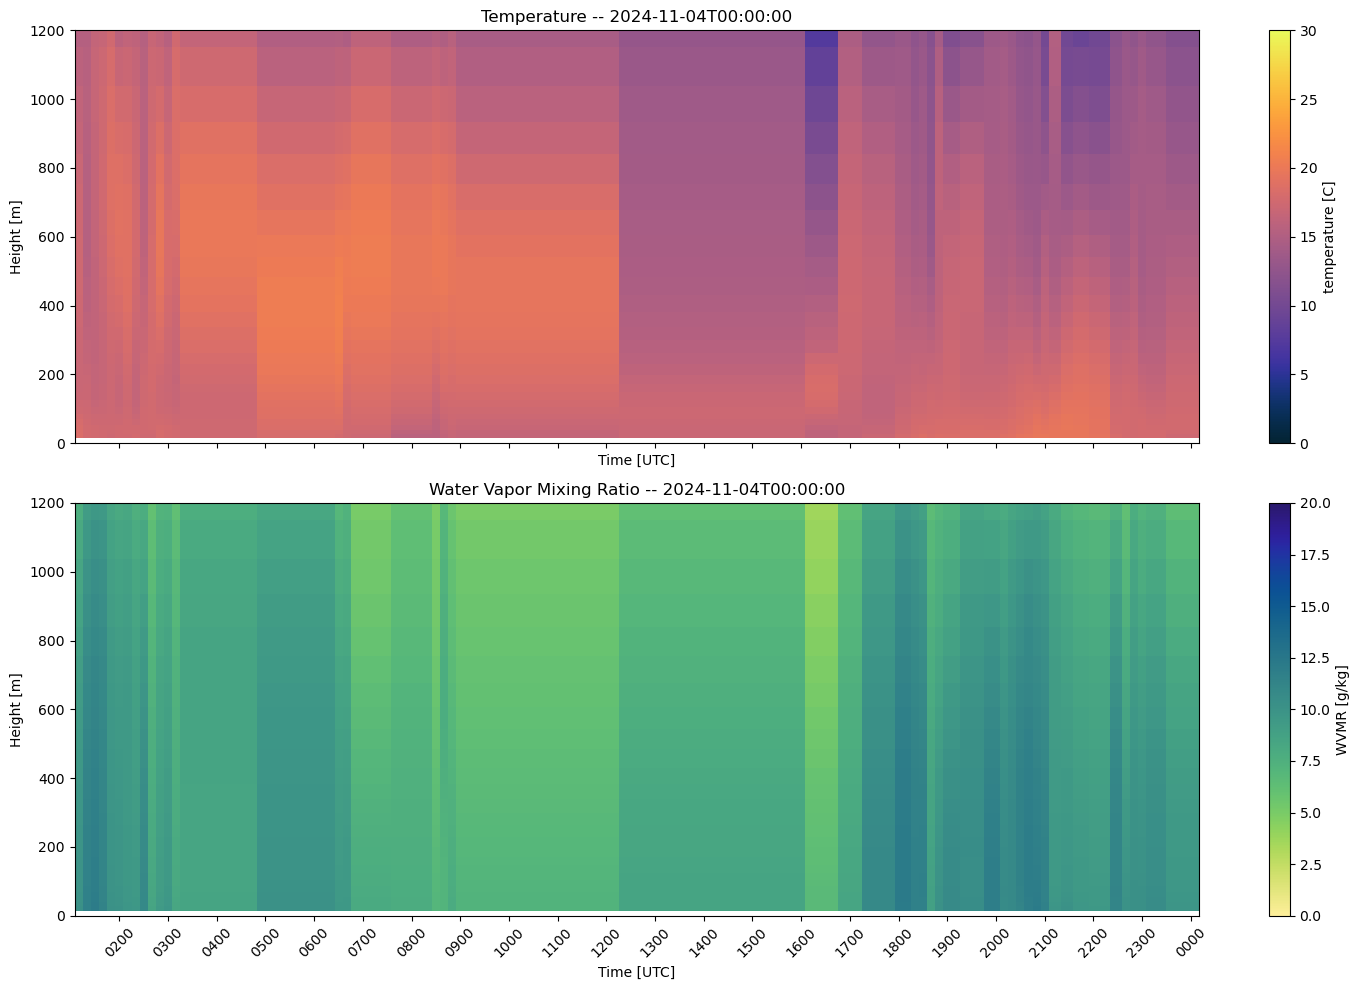

In [54]:
# Create our figure and set the width and height
fig, (wnd_spd, wnd_dir) =  plt.subplots(2, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

# Get the times and make sure they are sorted
t = [datetime.utcfromtimestamp(d) for d in (nc['base_time'][:]+nc['time_offset'][:])]

sort = np.argsort(t)
vad_times = np.array(t)[sort]
wspd = nc['temperature'][sort]
wdir = nc['waterVapor'][sort]
hgt = nc['height'][:] * 1000  # Convert the height to meters

# The first two gates of the Doppler lidar are usually bad data, so ignore the first two heights
hgt = hgt[2:]
wspd = wspd[:, 2:]
wdir = wdir[:, 2:]

# Grid the times and heights
time, hgt = np.meshgrid(vad_times, hgt)

# Plot the time heights
wnd_spd = timeheight(time, hgt, wspd.transpose(), 't', ax=wnd_spd, zmax=1200, zmin=0, datamin=0, datamax=30)
wnd_dir = timeheight(time, hgt, wdir.transpose(), 'q', ax=wnd_dir, zmax=1200, zmin=0, datamin=0, datamax=20)

# Convert wind speed and wind direction to the u and v component of the wind
#u, v = uv_from_spd_dir(wspd, wdir)

# Sometimes bad values can make it through, so lets filter out any winds > 50 m/s
#u = np.where(np.abs(u) < 50, u, np.nan)
#v = np.where(np.abs(v) < 50, v, np.nan)

# Plot the barbs on the wind direction axis
#skipx=3
#skipy=5
#wnd_dir.barbs(time[::skipx, ::skipy], hgt[::skipx, ::skipy], u.transpose()[::skipx, ::skipy], v.transpose()[::skipx, ::skipy])
dt = datetime(2024, 11, 4)
# Set the titles
wnd_spd.set_title("Temperature -- {}".format(dt.isoformat()))
wnd_dir.set_title("Water Vapor Mixing Ratio -- {}".format(dt.isoformat()))
    

plt.tight_layout()
plt.savefig('2b.png')
plt.show()

In [55]:

def uv_from_spd_dir(speed, wdir):
    wdir = np.deg2rad(wdir)
    u = -speed * np.sin(wdir)
    v = -speed * np.cos(wdir)
    return u, v

In [56]:
filename = 'clampsdlvadC2.c1.20241104.000000.cdf'
nc = Dataset(filename, 'r')
# Print out the netCDF header so you know what's in there
print (nc)

# Grab the times, heights, and data we're interested in 
times = np.array([datetime.utcfromtimestamp(d) for d in nc['base_time'][0]+nc['time_offset'][:]])
heights = nc['height'][:] * 1e3
wspd = nc['wspd'][:]
w = nc['w'][:]
wdir = nc['wdir'][:]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    System: CLAMPS Doppler Lidar
    Date created: 2024-11-04T00:15:45.418645
    dimensions(sizes): time(143), height(400)
    variables(dimensions): float64 height(height), int64 base_time(), float64 time_offset(time), float64 hour(time), float32 wdir(time, height), float32 wspd(time, height), float32 w(time, height), float32 rms(time, height), float32 r_sq(time, height), float32 intensity(time, height), float32 lat(time), float32 lon(time), float32 alt(time)
    groups: 


/var/folders/gs/zwmmp28x3fxdv4y3mz__qq280000gn/T/ipykernel_14680/4216506524.py:7: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  times = np.array([datetime.utcfromtimestamp(d) for d in nc['base_time'][0]+nc['time_offset'][:]])


/var/folders/gs/zwmmp28x3fxdv4y3mz__qq280000gn/T/ipykernel_14680/3044307701.py:7: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  t = [datetime.utcfromtimestamp(d) for d in (nc['base_time'][:]+nc['time_offset'][:])]


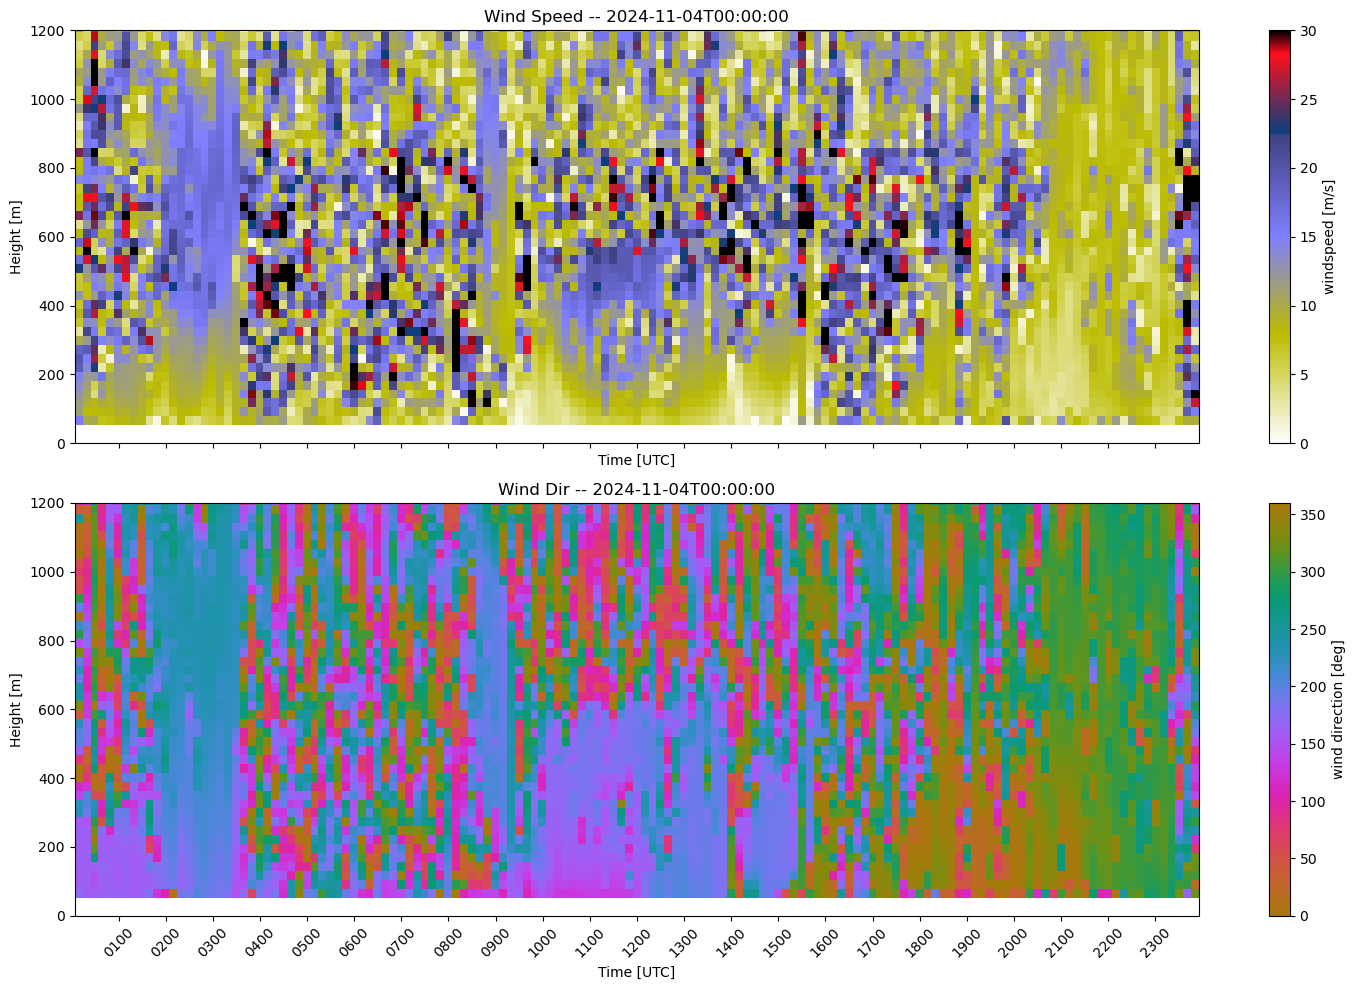

In [57]:
# Create our figure and set the width and height
fig, (wnd_spd, wnd_dir) =  plt.subplots(2, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

# Get the times and make sure they are sorted
t = [datetime.utcfromtimestamp(d) for d in (nc['base_time'][:]+nc['time_offset'][:])]

sort = np.argsort(t)
vad_times = np.array(t)[sort]
wspd = nc['wspd'][sort]
wdir = nc['wdir'][sort]
hgt = nc['height'][:] * 1000  # Convert the height to meters

# The first two gates of the Doppler lidar are usually bad data, so ignore the first two heights
hgt = hgt[2:]
wspd = wspd[:, 2:]
wdir = wdir[:, 2:]

# Grid the times and heights
time, hgt = np.meshgrid(vad_times, hgt)

# Plot the time heights
wnd_spd = timeheight(time, hgt, wspd.transpose(), 'ws', ax=wnd_spd, zmax=1200, zmin=0, datamin=0, datamax=30)
wnd_dir = timeheight(time, hgt, wdir.transpose(), 'wd', ax=wnd_dir, zmax=1200, zmin=0, datamin=0, datamax=360)

# Convert wind speed and wind direction to the u and v component of the wind
u, v = uv_from_spd_dir(wspd, wdir)

# Sometimes bad values can make it through, so lets filter out any winds > 50 m/s
u = np.where(np.abs(u) < 50, u, np.nan)
v = np.where(np.abs(v) < 50, v, np.nan)

# Plot the barbs on the wind direction axis
skipx=3
skipy=5
#wnd_dir.barbs(time[::skipx, ::skipy], hgt[::skipx, ::skipy], u.transpose()[::skipx, ::skipy], v.transpose()[::skipx, ::skipy])

# Set the titles
wnd_spd.set_title("Wind Speed -- {}".format(dt.isoformat()))
wnd_dir.set_title("Wind Dir -- {}".format(dt.isoformat()))
    
plt.tight_layout()
plt.savefig('2c.png')
plt.show()
